### Import Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import os
import time
import numpy as np
import matplotlib.pyplot as plt

### Simple Parameter Initialization:

In [2]:
params = {
    "b_size": , # batch size 
    "num_classes": 10, # number of classes (0,1,2,...,9)
    "epochs": 5, # total number of epochs
    "lr": 1e-4, # learning rate
}

### Data Loader

In [3]:
dataloader_train = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion_mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=params["b_size"],
    shuffle=True,
)


dataloader_test = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion_mnist",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=params["b_size"],
    shuffle=True,
)

### Simple Visualization:

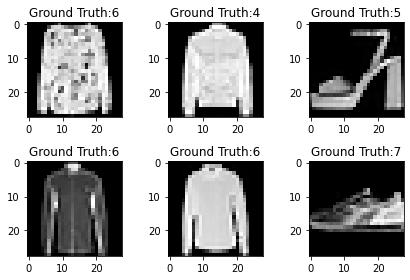

In [4]:
sample_batch = next(iter(dataloader_test))

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(torch.squeeze(sample_batch[0][i]), cmap='gray', interpolation=None) # use cmap='gray' for the gray images
    plt.title(f"Ground Truth:{sample_batch[1][i]}")
    

### Utils Functions:

In [5]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def make_dir():
    image_dir = "./output/images"
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
make_dir()

# for saving the reconstructed images
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img,name)

### Convolution AutoEncoder Model:

In [6]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder 
        #input: 28*28*1
        self.enc1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        #26*26*16
        self.enc2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        #24*24*32
        self.enc3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        #22*22*64
        self.enc4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        #20*20*128
        self.enc5 = nn.Conv2d(in_channels=128, out_channels=16, kernel_size=3, stride=1, padding=0)
        #output: 18*18*16
        
        # Decoder
        #input: 18*18*16
        self.dec1 = nn.ConvTranspose2d(in_channels=16, out_channels=128, kernel_size=3, stride=1, padding=0)
        #20*20*128
        self.dec2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0)
        #22*22*64
        self.dec3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0)
        #24*24*32
        self.dec4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0)
        #26*26*16
        self.dec5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=0)
        #output: 28*28*1
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu+eps*std
        
    def encode(self, img):
        img = F.relu(self.enc1(img))
        img = F.relu(self.enc2(img))
        img = F.relu(self.enc3(img))
        img = F.relu(self.enc4(img))
        img = F.relu(self.enc5(img))

        return img
        
    def decode(self, img):
        img = F.relu(self.dec1(img))
        img = F.relu(self.dec2(img))
        img = F.relu(self.dec3(img))
        img = F.relu(self.dec4(img))
        img = torch.sigmoid(self.dec5(img))

        return img

    def forward(self, img):
        img = self.encode(img)
        mu,logvar = img, img
        z = self.reparameterize(mu, logvar)
        img = self.decode(z)

        return img, mu, logvar

In [7]:
model = ConvVAE().to(get_device())
print(model)

ConvVAE(
  (enc1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (enc3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (enc4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (enc5): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(16, 128, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (dec3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (dec4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)


### Loss Function and Optimizer Selection:

In [8]:
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

In [9]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Training Function

In [10]:
def fit(model, dataloader, epoch):
    print("Training.....")
    model.train()
    running_loss = 0.0 
    counter = 0
    for i,data in enumerate(dataloader):
#     for i, data in tqdm(enumerate(dataloader), total=int(len(dataloader_train)/dataloader.batch_size)):
        counter += 1 
        data,_ = data
        data = data.to(get_device())
        data = data
#         print(data.shape)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    epoch_loss = running_loss/counter
    print(f"Training Loss: {epoch_loss:.3f}")
    outputs = reconstruction.view(reconstruction.size(0), 1, 28, 28).cpu().data
    save_image(outputs, f"./output/images/reconstruction{epoch}.png")
    
    return epoch_loss

### Validation Function:

In [11]:
def validate(model, dataloader, epoch):
    print("Validating.....")
    model.eval()
    running_loss = 0.0 
    counter = 0 
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            img, _ = data 
            img = img.to(get_device())
            reconstruction, mu, logvar = model(img)
            bce_loss = criterion(reconstruction, img)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
    epoch_loss = running_loss/counter
    print(f"val loss: {epoch_loss:.3f}")
    # Save Reconstructed Image
    outputs = reconstruction.view(reconstruction.size(0),1,28,28).cpu().data
    save_image(outputs, f"./output/images/reconstuction_val{epoch}.png")
    
    return epoch_loss

### Model Training:

In [12]:
train_loss = []
val_loss = []
start = time.time()
for epoch in range(params['epochs']):
    print(f"({epoch+1}/{params['epochs']})")
    train_epoch_loss = fit(model, dataloader_train, epoch)
    val_epoch_loss = validate(model, dataloader_test, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
end = time.time()
print(f"Total time to run the model: {(end-start)/60:.3f} minutes")

(1/5)
Training.....
Training Loss: 13265.088
Validating.....
val loss: 12567.582
(2/5)
Training.....
Training Loss: 12488.217
Validating.....
val loss: 12427.780
(3/5)
Training.....
Training Loss: 12415.741
Validating.....
val loss: 12404.398
(4/5)
Training.....
Training Loss: 12393.280
Validating.....
val loss: 12384.255
(5/5)
Training.....
Training Loss: 12381.066
Validating.....
val loss: 12372.145
Total time to run the model: 68.832 minutes


### Training and Validation Loss Visualization:

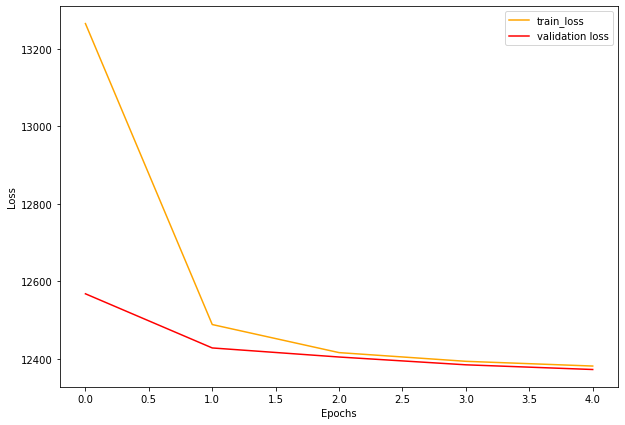

In [13]:
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='train_loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./output/loss.png")
plt.show()

### Model Saving:

In [14]:
torch.save(model.state_dict(), f"./output/convolution_autoEncoder.pth")